# 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (device="cuda"). Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 24.72 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [6]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" is equivalent to saying "best available"

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 122MB/s]


In [7]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [8]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [9]:
# Set seeds for reproducibility
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

In [10]:
# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [11]:
def create_effnetb2_model(num_classes:int=3, # Default output classes =3 (pizza, steak, sushi)
                          seed:int=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproduccibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

In [12]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [13]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32,)

In [14]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [15]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


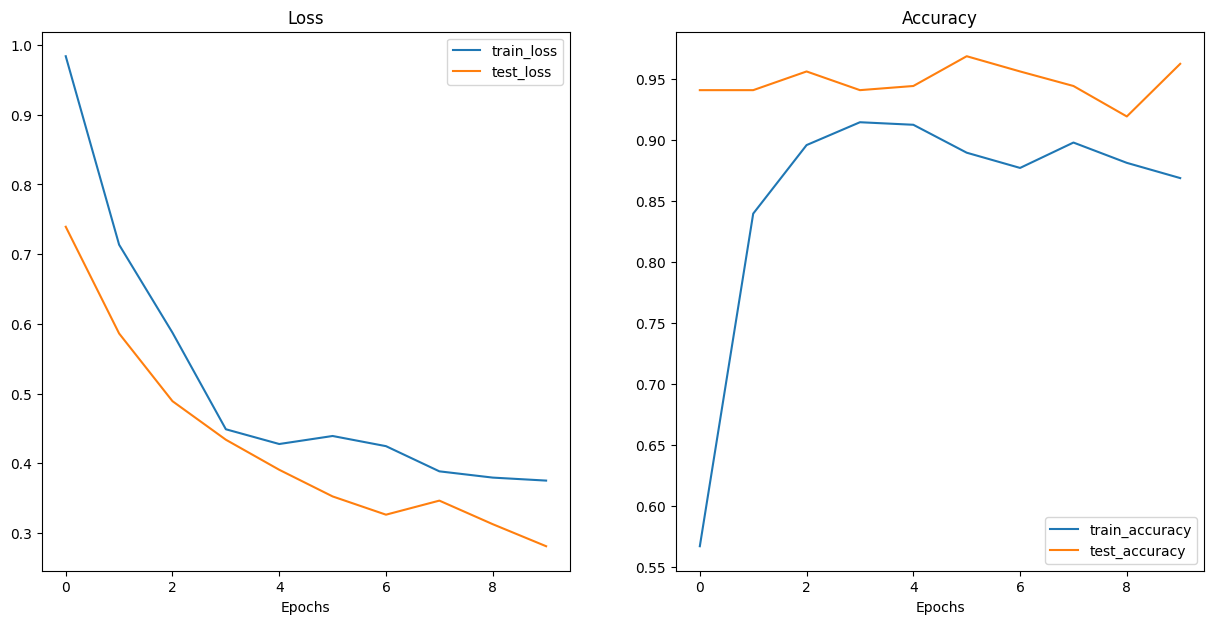

In [16]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [17]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [18]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size  / (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB")

Pretrained EffNetB2 feature extractor model size: 29.86 MB


In [19]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [20]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166}

In [21]:
# Check out the ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [22]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  # Create a ViT_B_16 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all of the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head to suit our needs
  torch.manual_seed(seed)
  model.heads = nn.Sequential(nn.Linear(in_features=768,
                                        out_features=num_classes))

  return model, transforms

In [23]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 114MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [24]:
# Print ViT model summary (uncomment for full output)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [25]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [26]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT feature extractor with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


In [27]:
# Save model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [28]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained ViT feature extractor model size {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size 327.37096977233887 MB


In [29]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [30]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

In [31]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/86782.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3497585.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/864661.jpg')]

In [32]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict


# 1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  # 2. Create an empty list (can return a full list of all predictions later).
  pred_list = []

  # 3. Loop through the target input paths (the rest of the steps will take place inside the loop).
  for path in tqdm(paths):

    # 4. Create an empty dictionary for each sample (prediction statistics will go in here).
    pred_dict = {}

    # 5. Get the sample path and ground truth class from the filepath.
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # 6. Start the prediction timer.
    start_time = timer()

    # 7. Open the image using `Image.open(path)`.
    img = Image.open(path)

    # 8. Transform the image to be usable with a given model (also add a batch dimension and send to target device).
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9. Prepare the model for inference by sending to the target device and turning on eval `eval()` mode.
    model = model.to(device)
    model.eval()

    # 10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
      pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probability into prediction label
      pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU (Python variables live on CPU)

      # 11. Add the pred prob + pred class to empty dictionary from step 4.
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # 12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time-start_time, 4)

    # 13. See if the predicted class matches the ground truth class.
    pred_dict["correct"] = class_name == pred_class

    # 14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
    pred_list.append(pred_dict)


  # 15. Return the list of prediction dictionaries.
  return pred_list

In [33]:
# Make predictions test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # hardcode predictions to happen on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [34]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.5239,sushi,0.2755,False
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.6168,steak,0.0935,True
2,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.7961,steak,0.0842,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.7606,steak,0.0986,True
4,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.4196,steak,0.0841,True


In [35]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [36]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.1275


In [37]:
# Add time per pred to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166,
 'time_per_pred_cpu': 0.1275}

In [38]:
# Make list of prediction dictionaries with ViT feature extrator model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                      model=vit,
                                      transform=vit_transforms,
                                      class_names=class_names,
                                      device="cpu") # hard device to CPU because not sure if GPU available when we deploy

  0%|          | 0/150 [00:00<?, ?it/s]

In [39]:
# Turn vit_test_pred_dicts
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.5065,sushi,0.5426,False
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.5870,steak,0.3829,True
2,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.9738,steak,0.3715,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9929,steak,0.3414,True
4,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.9630,steak,0.3455,True


In [40]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")

ViT average time per prediction: 0.4114


In [41]:
# Add average time per prediction to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37096977233887,
 'time_per_pred_cpu': 0.4114}

In [42]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281087,96.25,7705221,29.863886,0.1275,EffNetB2
1,0.064435,98.47,85800963,327.370970,0.4114,ViT


## 1.1 Make predictions with `cuda`

In [50]:
# Make predictions test dataset with EffNetB2
effnetb2_test_pred_dicts_cuda = pred_and_store(paths=test_data_paths,
                                              model=effnetb2,
                                              transform=effnetb2_transforms,
                                              class_names=class_names,
                                              device="cuda") # hardcode predictions to happen on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [48]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df_cuda = pd.DataFrame(effnetb2_test_pred_dicts_cuda)
effnetb2_test_pred_df_cuda.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.5239,sushi,0.0360,False
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.6168,steak,0.0260,True
2,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.7961,steak,0.0227,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.7606,steak,0.0233,True
4,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.4196,steak,0.0251,True


In [51]:
# Check number of correct predictions
effnetb2_test_pred_df_cuda.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [53]:
# Find the average time per prediction
effnetb2_average_time_per_pred_cuda = round(effnetb2_test_pred_df_cuda.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred_cuda}")

EffNetB2 average time per prediction: 0.0258


In [55]:
# Add time per pred to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred_gpu"] = effnetb2_average_time_per_pred_cuda
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166,
 'time_per_pred_cpu': 0.1275,
 'time_per_pred_gpu': 0.0258}

In [56]:
# Make list of prediction dictionaries with ViT feature extrator model on test images
vit_test_pred_dicts_cuda = pred_and_store(paths=test_data_paths,
                                          model=vit,
                                          transform=vit_transforms,
                                          class_names=class_names,
                                          device="cuda") # hard device to CPU because not sure if GPU available when we deploy

  0%|          | 0/150 [00:00<?, ?it/s]

In [57]:
# Turn vit_test_pred_dicts
import pandas as pd
vit_test_pred_df_cuda = pd.DataFrame(vit_test_pred_dicts_cuda)
vit_test_pred_df_cuda.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.5065,sushi,0.1257,False
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.5870,steak,0.0338,True
2,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.9738,steak,0.0291,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9929,steak,0.0283,True
4,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.9630,steak,0.0268,True


In [58]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred_cuda = round(vit_test_pred_df_cuda.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred_cuda}")

ViT average time per prediction: 0.0213


In [59]:
# Add average time per prediction to ViT stats
vit_stats["time_per_pred_gpu"] = vit_average_time_per_pred_cuda
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37096977233887,
 'time_per_pred_cpu': 0.4114,
 'time_per_pred_gpu': 0.0213}

In [60]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,time_per_pred_gpu,model
0,0.281087,96.25,7705221,29.863886,0.1275,0.0258,EffNetB2
1,0.064435,98.47,85800963,327.370970,0.4114,0.0213,ViT


# 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

In [102]:
# Create Food101 model and transforms
vit_food101, vit_transforms =  create_vit_model(num_classes=101)

In [103]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(vit_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 101]             768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [104]:
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [105]:
# Create training data transforms
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms
])
food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

In [106]:
from torchvision import datasets

# Setup data diretory
from pathlib import Path
data_dir = Path("data")

# Get the training data (-750 images x 101 classes)
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_train_transforms,
                              download=True)

# Get the testing data (-250 images x 101 classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=vit_transforms, # don't perform data augmentation on the test data
                             download=True)

In [107]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [108]:
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  # Create split lengths based on original datset length
  length_1 = int(len(dataset) * split_size)  # defaults to 20% data split
  length_2 = len(dataset) - length_1 # remaining length

  # Print out info
  print(f"[INFO] Spliting dataset of length {len(dataset)} into splits of  size: {length_1} and {length_2}")

  # Create splits with given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                 lengths=[length_1, length_2],
                                                                 generator=torch.manual_seed(seed))
  return random_split_1, random_split_2

In [109]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                              split_size=0.2)

# Create testing 20% split Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                             split_size=0.2)

[INFO] Spliting dataset of length 75750 into splits of  size: 15150 and 60600
[INFO] Spliting dataset of length 25250 into splits of  size: 5050 and 20200


In [110]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

In [111]:
import os

os.cpu_count()

2

In [112]:
import os
import torch

NUM_WORKERS = 2   # this value is very experimental and the best value will differ depending on the hardware you're using, search "python num workers setting for more"

BATCH_SIZE = 32

# Create Food101 20 training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

# Create Food101 20% testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

In [113]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

In [114]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit_food101.parameters(),
                             lr=1e-3)

# Setup loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Want to beat the original Food101 paper's result of 56.4% accuracy on the test dataset with 20% of the data
set_seeds()
vit_food101_results = engine.train(model=vit_food101,
                                   train_dataloader=train_dataloader_food101_20_percent,
                                   test_dataloader=test_dataloader_food101_20_percent,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=5,
                                   device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8532 | train_acc: 0.4279 | test_loss: 2.0665 | test_acc: 0.6257
Epoch: 2 | train_loss: 2.2209 | train_acc: 0.5931 | test_loss: 1.9249 | test_acc: 0.6657
Epoch: 3 | train_loss: 2.0587 | train_acc: 0.6439 | test_loss: 1.8675 | test_acc: 0.6981
Epoch: 4 | train_loss: 1.9557 | train_acc: 0.6810 | test_loss: 1.8514 | test_acc: 0.6989
Epoch: 5 | train_loss: 1.8883 | train_acc: 0.7009 | test_loss: 1.8297 | test_acc: 0.7078


In [115]:
from going_modular.going_modular import utils

# Create a model path
vit_food101_model_path = "09_pretrained_vit_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=vit_food101,
                 target_dir="models/",
                 model_name=vit_food101_model_path)

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_food101_20_percent.pth


In [116]:
# Create Food101 compatible vit instance
loaded_vit_food101, vit_transforms = create_vit_model(num_classes=101)

# Load the saved model's state_dict()
loaded_vit_food101.load_state_dict(torch.load("models/09_pretrained_vit_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

In [117]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models", vit_food101_model_path).stat().st_size / (1024 * 1024)
print(f"Pretrained vit feature extractor model size {pretrained_vit_model_size} MB")

Pretrained vit feature extractor model size 327.6569576263428 MB


# 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions.

In [126]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/86782.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3497585.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/864661.jpg')]

In [118]:
# Make predictions test dataset with vit
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit_food101,
                                     transform=vit_transforms,
                                     class_names=food101_class_names,
                                     device="cuda") # hardcode predictions to happen on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [119]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.2586,
  'pred_class': 'ramen',
  'time_for_pred': 0.0397,
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.1701,
  'pred_class': 'chicken_wings',
  'time_for_pred': 0.0291,
  'correct': False}]

In [120]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.2586,ramen,0.0397,False
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.1701,chicken_wings,0.0291,False
2,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.3091,steak,0.0284,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.2973,steak,0.0327,True
4,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.2555,filet_mignon,0.0291,False


In [121]:
# Check number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True     102
False     48
Name: count, dtype: int64

In [122]:
# Find the average time per prediction
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"vit average time per prediction: {vit_average_time_per_pred}")

vit average time per prediction: 0.0223


In [123]:
# Add time per pred to EffNetB2 stats dictionary
vit_stats["time_per_pred_gpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37096977233887,
 'time_per_pred_cpu': 0.4114,
 'time_per_pred_gpu': 0.0223}

In [124]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(vit_test_pred_dicts)
# Sort DataFrame by correct then by pred_prob
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
91,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.5871,sashimi,0.0203,False
138,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.5354,chicken_quesadilla,0.0225,False
79,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.5301,sashimi,0.0277,False
31,data/pizza_steak_sushi_20_percent/test/steak/6...,steak,0.4895,baby_back_ribs,0.0220,False
94,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.4748,sashimi,0.0238,False


# 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?

In [148]:
len(test_data)

25250

In [157]:
# Turn Food101 test data into DataLoader
# Easy way: set up batch size of 1 of test data loader - from Sali1997s
# Create batch size of 1 (predict on 1 image at a time)
test_dataloader_food101_all_data_batch_size_1 = torch.utils.data.DataLoader(test_data,
                                                                            batch_size=1,
                                                                            shuffle=False,
                                                                            num_workers=NUM_WORKERS)

len(test_dataloader_food101_all_data_batch_size_1)

25250

In [158]:
# Prepare model (do this outside the loop)
vit_food101_20_percent = vit_food101.to(device)
vit_food101_20_percent.eval()

# Loop through test DataLoader with batch size 1 and make predictions on each image
# store predictions and truth values to a dictionary and then append dictionary to list for inspection later
vit_food101_all_test_data_pred_list = []
for X, y in tqdm(test_dataloader_food101_all_data_batch_size_1 ):
  # Send data to target device
  X, y = X.to(device), y.to(device)

  # Create empty prediction dictionary (each sample gets a dictionary)
  pred_dict = {}

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]

  vit_food101_all_test_data_pred_list.append(pred_dict)


  0%|          | 0/25250 [00:00<?, ?it/s]

In [159]:
# Evalaute model on entire test set
food101_all_test_data_df = pd.DataFrame(vit_food101_all_test_data_pred_list)
food101_all_test_data_df["is_correct"] = food101_all_test_data_df["pred_label"] == food101_all_test_data_df["label"]
food101_all_test_data_df.is_correct.value_counts()

is_correct
True     17849
False     7401
Name: count, dtype: int64

In [160]:
# Calculate accuracy across Food101 all test
print(f"Accuracy of ViT model on all of Food101 test data: {food101_all_test_data_df.is_correct.value_counts()[1] / len(food101_all_test_data_df)}")

Accuracy of ViT model on all of Food101 test data: 0.2931089108910891


# 5. Head to Paperswithcode.com and find the current best performing model on the Food101 dataset.
* What model architecture does it use?

The best model is Context-aware Attentional Pooling (CAP) for Fine-grained Visual Classification with an accuracy of 98.6%

# 6. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.
* For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?

Problems:
1. **Someone uploads a photo that isn't food...**
  * Potential solution: train two models, one that classifies images into "food" or "not food" and if an image is found to be "not food" display a message, if it is found to be "food", classify it into a certain class.
2. **Someone uploads a photo of food but our model doesn't have the capacity to classify that certain class...**
  * Potential solutions:
    1. Get more data for unknown classes (upgrade the model).
    2. Ask someone if the prediction is right/wrong, if it's wrong, track it to a database and update later (active learning - https://en.wikipedia.org/wiki/Active_learning_(machine_learning)).
3. **The image quality is poor (food in top left of image rather than center)**
  * Potential solution: add guidelines to the camera app to hint at taking a photo with the subject in the middle
4. **Multiple foods in one shot**
  * Potential solution:
    1. Return multiple classification results (e.g. the top 5 classification predication probabilities)
    2. Object detection (detect each different food in an image and individually classify them)

# 7. Pick any dataset from torchvision.datasets and train a feature extractor model on it using a model from torchvision.models (you could use one of the model's we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces.
You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
I'd love to see your deployed models! So be sure to share them in Discord or on the course GitHub Discussions page.

In [203]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from PIL import Image

# Custom transform to handle grayscale images by converting them to RGB
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img

# Define a transform to normalize the data
transform = transforms.Compose([
    ConvertToRGB(),  # Convert images to RGB format
    transforms.Resize((224, 224)),  # Resize the images to 224x224 pixels
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Normalize the images
])

# Load the Caltech 101 dataset
dataset = datasets.Caltech101(root='path_to_data', download=True, transform=transform)

# Define the size of the train and test sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders to iterate through the datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Files already downloaded and verified


In [204]:
img, label = train_dataset[0]
img, label

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 36)

In [205]:
class_names = dataset.categories

print("Class names:", class_names)

Class names: ['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ba

Text(0.5, 1.0, 'elephant')

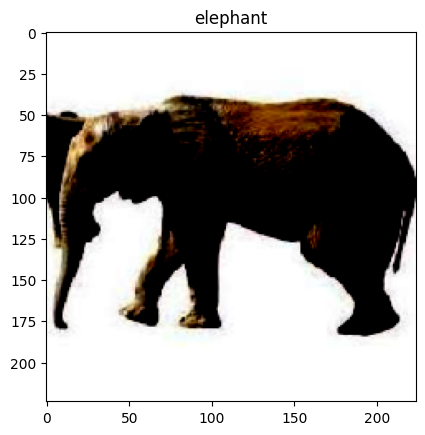

In [206]:
import matplotlib.pyplot as plt
plt.imshow(img.permute(1,2,0), cmap="gray")
plt.title(class_names[label])

In [207]:
# Create Caltech101 model and transforms
vit_caltech101, vit_transforms =  create_vit_model(num_classes=101)

In [208]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit_caltech101.parameters(),
                             lr=1e-3)

# Setup loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)


set_seeds()
vit_caltech101_results = engine.train(model=vit_caltech101,
                                   train_dataloader=train_loader,
                                   test_dataloader=test_loader,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=5,
                                   device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6003 | train_acc: 0.8392 | test_loss: 1.0150 | test_acc: 0.9517
Epoch: 2 | train_loss: 0.9391 | train_acc: 0.9729 | test_loss: 0.9755 | test_acc: 0.9636
Epoch: 3 | train_loss: 0.8797 | train_acc: 0.9896 | test_loss: 0.9679 | test_acc: 0.9682
Epoch: 4 | train_loss: 0.8540 | train_acc: 0.9937 | test_loss: 0.9643 | test_acc: 0.9670
Epoch: 5 | train_loss: 0.8398 | train_acc: 0.9958 | test_loss: 0.9665 | test_acc: 0.9659


In [209]:
from going_modular.going_modular import utils

# Create a model path
vit_caltech101_model_path = "09_pretrained_vit_feature_extractor_caltech_100_percent.pth"

# Save FoodVision Big model
utils.save_model(model=vit_caltech101,
                 target_dir="models/",
                 model_name=vit_caltech101_model_path)

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_caltech_100_percent.pth


In [210]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models", vit_caltech101_model_path).stat().st_size / (1024 * 1024)
print(f"Pretrained vit feature extractor model size {pretrained_vit_model_size} MB")

Pretrained vit feature extractor model size 327.65710639953613 MB
